<a href="https://colab.research.google.com/github/SunkeSruthi603/Brain_Tumor/blob/main/Brain_Tumor_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install scikit-learn
!pip install split-folders
!pip install tensorflow
!pip install opencv-python
!pip install imutils
!pip install seaborn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, shutil
import cv2
import time
import zipfile
import tensorflow as tf
import imutils
import splitfolders
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import Sequential
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
plt.style.use("ggplot")

In [2]:
#2.Extracting the Data
from google.colab import files
files.upload()  # Upload kaggle.json here


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sruthisunke","key":"23dee1ebcb3ae0eb8a3429747bb9142c"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d sartajbhuvaji/brain-tumor-classification-mri

Dataset URL: https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri
License(s): MIT
  0% 0.00/86.8M [00:00<?, ?B/s]
100% 86.8M/86.8M [00:00<00:00, 1.31GB/s]


In [5]:
!unzip brain-tumor-classification-mri.zip -d "Brain Tumor Dataset"

Archive:  brain-tumor-classification-mri.zip
  inflating: Brain Tumor Dataset/Testing/glioma_tumor/image(1).jpg  
  inflating: Brain Tumor Dataset/Testing/glioma_tumor/image(10).jpg  
  inflating: Brain Tumor Dataset/Testing/glioma_tumor/image(100).jpg  
  inflating: Brain Tumor Dataset/Testing/glioma_tumor/image(11).jpg  
  inflating: Brain Tumor Dataset/Testing/glioma_tumor/image(12).jpg  
  inflating: Brain Tumor Dataset/Testing/glioma_tumor/image(13).jpg  
  inflating: Brain Tumor Dataset/Testing/glioma_tumor/image(14).jpg  
  inflating: Brain Tumor Dataset/Testing/glioma_tumor/image(15).jpg  
  inflating: Brain Tumor Dataset/Testing/glioma_tumor/image(16).jpg  
  inflating: Brain Tumor Dataset/Testing/glioma_tumor/image(17).jpg  
  inflating: Brain Tumor Dataset/Testing/glioma_tumor/image(18).jpg  
  inflating: Brain Tumor Dataset/Testing/glioma_tumor/image(19).jpg  
  inflating: Brain Tumor Dataset/Testing/glioma_tumor/image(2).jpg  
  inflating: Brain Tumor Dataset/Testing/gliom

In [6]:
#3.EDA
base_path = "/content/Brain Tumor Dataset/Training"
tumor_types = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]

def count_files(base_path):
  for tumor_type in tumor_types:
    folder_path = os.path.join(base_path, tumor_type)
    if os.path.exists(folder_path):
      file_list = os.listdir(folder_path)
      print(f"Number of files in {tumor_type}: {len(file_list)}")
    else:
      print(f"Folder not found: {folder_path}")

print ("Brain Tumor MRI Dataset EDA")
count_files(base_path)

Brain Tumor MRI Dataset EDA
Number of files in glioma_tumor: 826
Number of files in meningioma_tumor: 822
Number of files in no_tumor: 395
Number of files in pituitary_tumor: 827


In [7]:

#4.Data Augmentation
def timing(sec_elapsed):
  h = int(sec_elapsed / (60 * 60))
  m = int((sec_elapsed % (60 * 60)) / 60)
  s = sec_elapsed % 60
  return f"{h}:{m}:{s}"


def augmented_data(base_dir, n_generated_samples, save_base_dir):
  data_gen = ImageDataGenerator(
      rotation_range=10,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      brightness_range=(0.3,0.1),
      horizontal_flip=True,
      vertical_flip=True,
      fill_mode='nearest'
  )

  start_time = time.time()

  for tumor_type in tumor_types:
      source_dir = os.path.join(base_dir, tumor_type)
      save_dir = os.path.join(save_base_dir, tumor_type)
      os.makedirs(save_dir, exist_ok=True)

      for filename in os.listdir(source_dir):
        image = cv2.imread(os.path.join(source_dir, filename))
        image = image.reshape((1,) + image.shape)
        save_prefix = 'aug_' + filename[:-4]
        i =0

        for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_dir, save_prefix=save_prefix, save_format="jpg"):
          i+=1
          if(i>= n_generated_samples):
            break

  end_time = time.time()
  print(f"Data augmentation completed in: {timing(end_time-start_time)}")

base_dir = '/content/Brain Tumor Dataset/Training'
n_generated_samples = 5
save_base_dir = '/content/Augmented Data'
augmented_data(base_dir, n_generated_samples, save_base_dir)

Data augmentation completed in: 0:13:14.78226900100708


In [8]:
#5.Renaming files
def rename_files(folder, tumor_name):
  count = 1
  for filename in os.listdir(folder):
    source = os.path.join(folder, filename)
    destination = os.path.join(folder, f"{tumor_name}_{count}.jpg")
    os.rename(source, destination)
    count += 1
  print(f"{tumor_name} Tumor Images Renamed Successfully")

for tumor in tumor_types:
  folder = f'/content/Augmented Data/{tumor}'
  rename_files(folder, tumor)

glioma_tumor Tumor Images Renamed Successfully
meningioma_tumor Tumor Images Renamed Successfully
no_tumor Tumor Images Renamed Successfully
pituitary_tumor Tumor Images Renamed Successfully


Tumor type counts (Augmented Date): [4127, 4110, 1975, 4133]


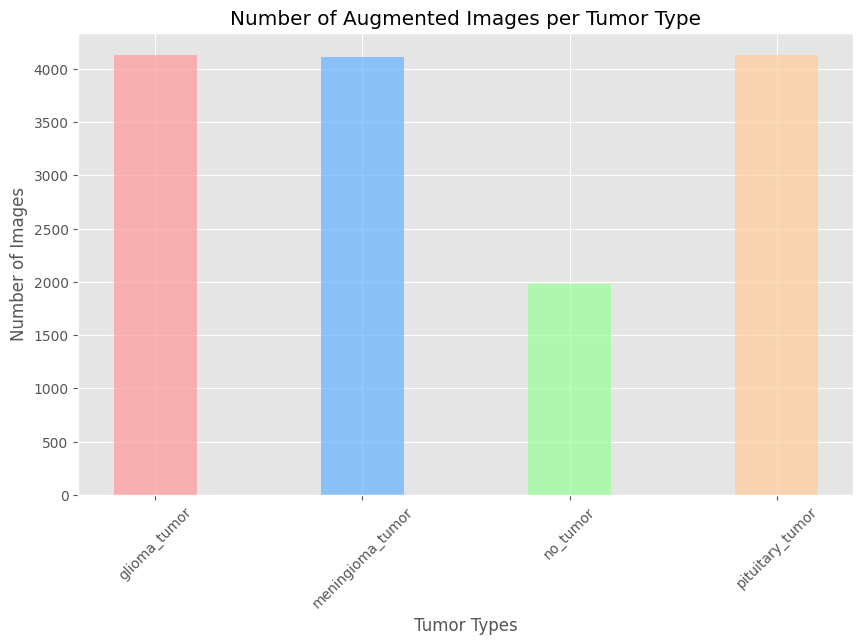

In [9]:
#6.Visualize Dataset
tumor_counts = [len(os.listdir(os.path.join(save_base_dir, tumor))) for tumor in tumor_types]
print("Tumor type counts (Augmented Date):", tumor_counts)

colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']
x = np.arange(len(tumor_types))
width = 0.4

plt.figure(figsize=(10, 6))
plt.bar(x, tumor_counts, width=width, align='center' , alpha=0.7, color=colors)
plt.xlabel('Tumor Types')
plt.ylabel('Number of Images')
plt.title('Number of Augmented Images per Tumor Type')
plt.xticks(x, tumor_types , rotation=45)
plt.show()

In [10]:
#7.Croping Brain Tumors by removing the black parts
def crop_brain_tumor(image):
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  gray = cv2.GaussianBlur(gray, (5,5), 0)
  thres = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
  thres = cv2.erode(thres, None, iterations=2)
  thres = cv2.dilate(thres, None, iterations=2)
  cnts = cv2.findContours(thres.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnts = imutils.grab_contours(cnts)

  if len(cnts) == 0:
    return image
  c = max(cnts, key=cv2.contourArea)
  extLeft = tuple(c[c[:, :, 0].argmin()][0])
  extRight = tuple(c[c[:, :, 0].argmax()][0])
  extTop = tuple(c[c[:, :, 1].argmin()][0])
  extBot = tuple(c[c[:, :, 1].argmax()][0])

  cropped_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]
  return cropped_image

def crop_and_save_images(folder_path):
  for filename in os.listdir(folder_path):
    image_path = os.path.join(folder_path, filename)
    image = cv2.imread(image_path)

    if image is not None:
      cropped_image = crop_brain_tumor(image)
      cv2.imwrite(image_path, cropped_image)
      print(f"Processed: {filename}")
    else:
      print(f"Failed to read: {filename}")
for tumor in tumor_types:
  folder_path = os.path.join(save_base_dir, tumor)
  print(f"Processing folder: {folder_path}")
  crop_and_save_images(folder_path)

Streaming output truncated to the last 5000 lines.
Processed: no_tumor_1838.jpg
Processed: no_tumor_1176.jpg
Processed: no_tumor_714.jpg
Processed: no_tumor_99.jpg
Processed: no_tumor_1725.jpg
Processed: no_tumor_1904.jpg
Processed: no_tumor_1524.jpg
Processed: no_tumor_218.jpg
Processed: no_tumor_1727.jpg
Processed: no_tumor_167.jpg
Processed: no_tumor_305.jpg
Processed: no_tumor_232.jpg
Processed: no_tumor_17.jpg
Processed: no_tumor_1008.jpg
Processed: no_tumor_357.jpg
Processed: no_tumor_666.jpg
Processed: no_tumor_1486.jpg
Processed: no_tumor_1634.jpg
Processed: no_tumor_1253.jpg
Processed: no_tumor_227.jpg
Processed: no_tumor_1414.jpg
Processed: no_tumor_1732.jpg
Processed: no_tumor_1791.jpg
Processed: no_tumor_9.jpg
Processed: no_tumor_1098.jpg
Processed: no_tumor_544.jpg
Processed: no_tumor_692.jpg
Processed: no_tumor_1055.jpg
Processed: no_tumor_1614.jpg
Processed: no_tumor_1860.jpg
Processed: no_tumor_246.jpg
Processed: no_tumor_1680.jpg
Processed: no_tumor_1606.jpg
Processed:

In [11]:
#8.split Data

input_folder = '/content/Augmented Data'
output_folder = '/content/Split Data'

splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(0.8, 0.1, 0.1))
print("Dataset successfully split into trainingg , validation and test sets")

Copying files: 14345 files [00:02, 6310.53 files/s]

Dataset successfully split into trainingg , validation and test sets


In [13]:
import shutil
from google.colab import files

shutil.make_archive('Split_Data_Brain', 'zip', '/content/Split Data')

files.download('Split_Data_Brain.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [14]:
#9.CNN model

def build_cnn_model():
  model = Sequential([
      layers.Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
      layers.MaxPooling2D((2,2)),
      layers.Conv2D(64, (3,3), activation='relu'),
      layers.MaxPooling2D((2,2)),
      layers.Conv2D(128, (3,3), activation='relu'),
      layers.MaxPooling2D((2,2)),
      layers.Flatten(),
      layers.Dense(128, activation='relu'),
      layers.Dropout(0.5),
      layers.Dense(4, activation='softmax') # 4 classes
  ])

  model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  return model

model = build_cnn_model()
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,156 (12.61 MB)

 Trainable params: 3,305,156 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
#10.Prepare Data Generators

train_dir = '/content/Split Data/train'
val_dir = '/content/Split Data/val'
test_dir = '/content/Split Data/test'

train_datagen = ImageDataGenerator(
    rescale=1./225,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./225)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

Found 11475 images belonging to 4 classes.
Found 1433 images belonging to 4 classes.
Found 1437 images belonging to 4 classes.


In [17]:
#Training the model

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True)

history = model.fit(
    train_generator,
    epochs = 5,
    validation_data = val_generator,
    callbacks =[early_stop, checkpoint]
)

Epoch 1/5
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.4031 - loss: 1.2506

359/359 ━━━━━━━━━━━━━━━━━━━━ 65s 182ms/step - accuracy: 0.4033 - loss: 1.2502 - val_accuracy: 0.5464 - val_loss: 1.0384
Epoch 2/5
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.6438 - loss: 0.8503

359/359 ━━━━━━━━━━━━━━━━━━━━ 62s 171ms/step - accuracy: 0.6438 - loss: 0.8503 - val_accuracy: 0.6846 - val_loss: 0.8004
Epoch 3/5
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.7106 - loss: 0.7303

359/359 ━━━━━━━━━━━━━━━━━━━━ 62s 171ms/step - accuracy: 0.7106 - loss: 0.7302 - val_accuracy: 0.7467 - val_loss: 0.6112
Epoch 4/5
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.7681 - loss: 0.5821

359/359 ━━━━━━━━━━━━━━━━━━━━ 61s 171ms/step - accuracy: 0.7681 - loss: 0.5820 - val_accuracy: 0.8207 - val_loss: 0.4674
Epoch 5/5
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.7903 - loss: 0.5197

359/359 ━━━━━━━━━━━━━━━━━━━━ 61s 171ms/step - accuracy: 0.7903 - loss: 0.5196 - val_accuracy: 0.8318 - val_loss: 0.4344


In [18]:
#Evaluate
loss, accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - accuracy: 0.8288 - loss: 0.4197
Test Accuracy: 82.46%


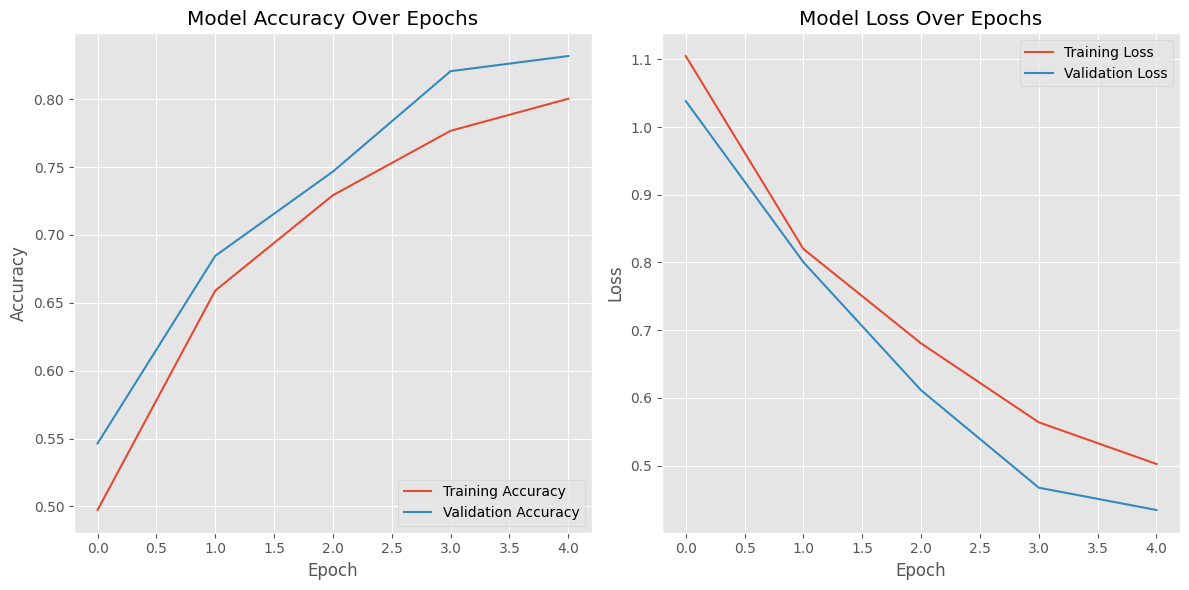

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


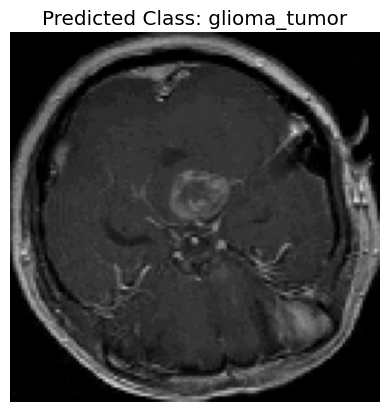

In [20]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Load the trained model
model = tf.keras.models.load_model('/content/best_model.h5')
class_names = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

def load_and_preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(128, 128))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array/ 255.0
    return img, img_array

def predict_image(image_path):
    img, img_array = load_and_preprocess_image(image_path)
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Predicted Class: {class_names[predicted_class[0]]}')
    plt.show()
    # plt.title(f'Predicted Class: {class_names[predicted_class[0]]}')

img_path = '/content/Split Data/test/glioma_tumor/glioma_tumor_101.jpg'
predict_image(img_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


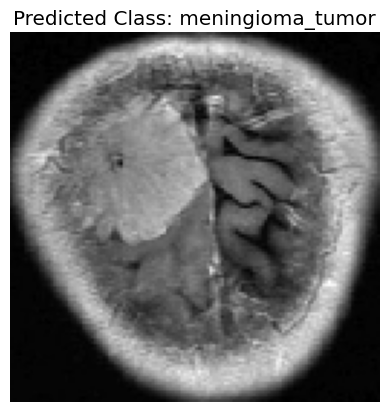

In [22]:
img_path = '/content/Split Data/test/meningioma_tumor/meningioma_tumor_100.jpg'
predict_image(img_path)